In [2]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import mlab

import os
import json
from glob import glob

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath, Variable

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [3]:
NFFT = 1024
SAMPLE_RATE = 2_048_000
H21 = 1.420405751768e9  # Hz

METERS_PER_PARSEC = 3.0857e16
EARTH_GALACTIC_CENTER = 8.5  # kpc, IAU
V0 = 220e3  # m/s, source: IAU apparently, unable to find
OORT_A = ufloat(15.3e3, 0.4e3)  # m s−1 kpc−1

In [89]:
def load(dataset: str):
    raw_data = np.fromfile(dataset, np.complex64)
    with open(dataset.replace("raw.dat", "params.json"), "r") as file:
        params = json.load(file)
    
    spectrum, frequencies = mlab.psd(raw_data, NFFT=NFFT, Fs=SAMPLE_RATE)
    frequencies += params['frequency']

    return raw_data, (spectrum, frequencies), params

In [109]:
data = []
noise = None
freq = None

files = sorted(glob("../data/h_*.dat"))
files.sort(key=os.path.getmtime)

for file in files:
    _, (spectrum, freq), params = load(file)
    params['l'] = ufloat(file.split('data/h_')[1].split('_')[0], 1)
    data.append((spectrum, params))

_, (noise, _), _ = load("../data/bc_test3_2025_02_28_13_31_31_raw.dat")

In [7]:
def gaussian(x: np.ndarray, A: float, B: float, mu: float, sigma: float) -> np.ndarray:
    return A + B * np.exp(-(x - mu)**2 / (2 * sigma**2))

In [8]:
def deg2rad(deg: float | Variable) -> float | Variable:
    return np.pi * deg / 180

In [9]:
def calculate_average(spectrum: np.ndarray) -> float:
    idx = np.r_[200:500,550:850]
    return np.mean(spectrum[idx])

In [10]:
def normalise_data(signal: np.ndarray, noise: np.ndarray) -> np.ndarray:
    return signal / noise

In [11]:
def clean_up(signal: np.ndarray, w: int = 10) -> np.ndarray:
    cleaned = np.convolve(signal, np.ones(w), 'same') / w
    return cleaned

In [12]:
def calculate_relative_velocity(measured_frequency: float | Variable) -> float | Variable:
    return sc.constants.c * (H21 - measured_frequency) / measured_frequency

In [80]:
def bad_distance_estimate(relative_velocity: float | Variable, galactic_longitude: float | Variable) -> float | Variable:
    galactic_rad = deg2rad(galactic_longitude)
    d = relative_velocity / OORT_A / unp.sin(2 * galactic_rad)
    return abs(d)

In [81]:
def velocity_vector_method(relative_velocity: float | Variable, galactic_longitude: float | Variable) -> float | Variable:
    galactic_rad = deg2rad(galactic_longitude)

    d = bad_distance_estimate(relative_velocity, galactic_longitude)
    R = unp.sqrt(EARTH_GALACTIC_CENTER**2 + d**2 - 2 * EARTH_GALACTIC_CENTER * d * unp.cos(galactic_rad))

    V_hydrogen_cloud = R / EARTH_GALACTIC_CENTER * (relative_velocity / unp.sin(galactic_rad) + V0)
    return V_hydrogen_cloud

In [82]:
def matteo_method(relative_velocity: float | Variable, galactic_longitude: float | Variable) -> float | Variable:
    galactic_rad = deg2rad(galactic_longitude)

    d = bad_distance_estimate(relative_velocity, galactic_longitude)
    R = unp.sqrt(EARTH_GALACTIC_CENTER**2 + d**2 - 2 * EARTH_GALACTIC_CENTER * d * unp.cos(galactic_rad))

    cos_alpha = (R**2 + d**2 - EARTH_GALACTIC_CENTER**2) / (2 * R * d)
    V_hydrogen_cloud = (relative_velocity + V0 * unp.sin(galactic_rad)) / unp.sqrt(1 - cos_alpha**2)
    return V_hydrogen_cloud

In [98]:
def do_the_processing_mate(freq: np.ndarray, spectrum: np.ndarray, params: dict, noise: np.ndarray, peaks_idx: list[int] = None, display: bool = True) -> Variable:
    cleaned_signal = clean_up(normalise_data(spectrum, noise), w=5)
    
    if peaks_idx is None:
        max_idx = np.argmax(cleaned_signal)
        freq_of_max = ufloat(freq[max_idx], 0.00002e9)  # estimated error based on vibes
    else:
        if len(peaks_idx) > 1: print("WARNING: only uses the first value currently")
        freq_of_max = ufloat(freq[peaks_idx[0]], 0.00002e9)  # estimated error based on vibes

    relative_velocity = calculate_relative_velocity(freq_of_max)
    
    l: float = params.get('l', 0)
    actual_velocity: Variable = None
    # Inner circle
    if l < 90:
        actual_velocity = velocity_vector_method(relative_velocity, l)
    # Outer circle
    elif l < 270:
        print(f"WARNING: using the bad method for {l=:.0f}")
        actual_velocity = matteo_method(relative_velocity, l)

    if display:
        print(f"Estimated relative velocity ({l=:.1uP}): {relative_velocity/1000:.3upP} km/s")
        print(f"Estimated actual velocity ({l=:.1uP}): {actual_velocity/1000:.3upP} km/s")
        plt.semilogy(freq, cleaned_signal)
        plt.axvline(H21, c='r', label='Base H21', ls='--')
        plt.axvline(freq_of_max.n, c='magenta', label='Shifted peak')
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Signal-to-noise ratio")
        plt.legend()
    
    distance_est = bad_distance_estimate(relative_velocity, l)

    return distance_est, actual_velocity, l

Spectrum [0]
Estimated relative velocity (l=3±1): (-17.36±4.22) km/s
Estimated actual velocity (l=3±1): (-31.6±96.1) km/s


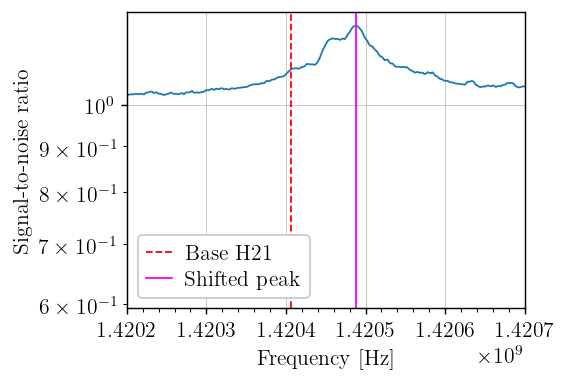

Spectrum [1]
Estimated relative velocity (l=6±1): (-16.09±4.22) km/s
Estimated actual velocity (l=6±1): (27.3±31.6) km/s


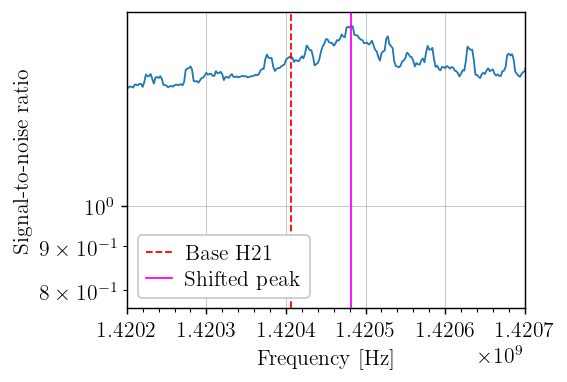

Spectrum [2]
Estimated relative velocity (l=9±1): (-16.51±4.22) km/s
Estimated actual velocity (l=9±1): (68.4±30.2) km/s


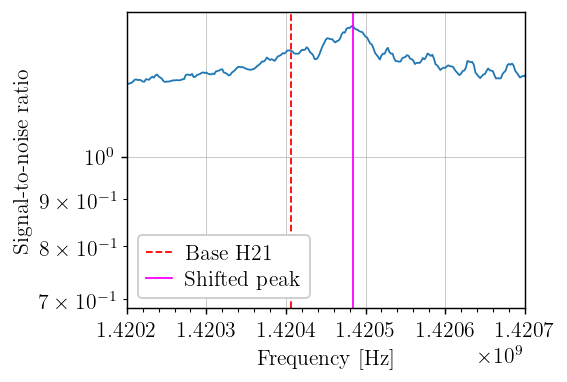

Spectrum [3]
Estimated relative velocity (l=12±1): (-16.51±4.22) km/s
Estimated actual velocity (l=12±1): (98.1±26.2) km/s


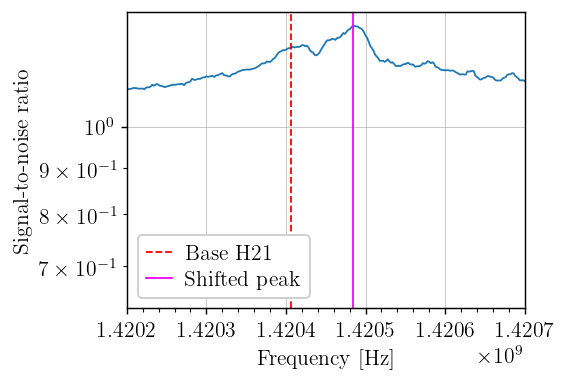

Spectrum [4]
Estimated relative velocity (l=15±1): (-17.78±4.22) km/s
Estimated actual velocity (l=15±1): (111.9±22.1) km/s


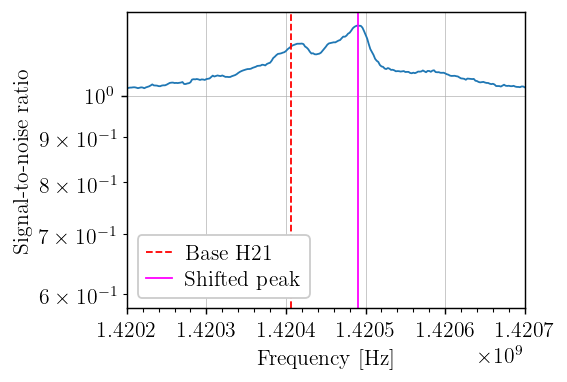

Spectrum [5]
Estimated relative velocity (l=18±1): (-17.78±4.22) km/s
Estimated actual velocity (l=18±1): (127.1±19.4) km/s


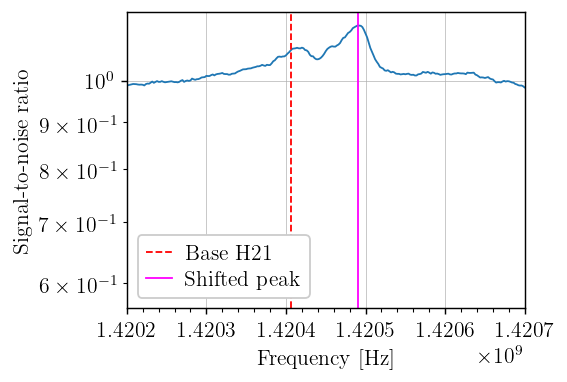

Spectrum [6]
Estimated relative velocity (l=21±1): (-18.20±4.22) km/s
Estimated actual velocity (l=21±1): (136.8±17.2) km/s


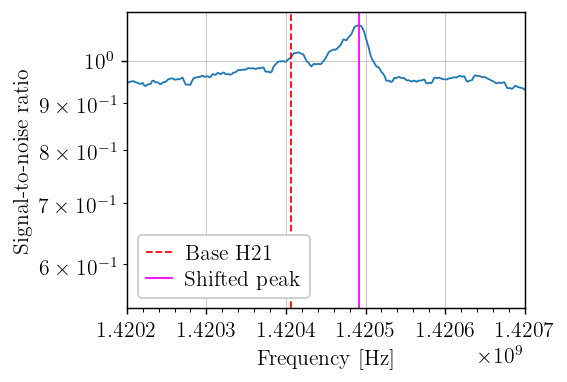

Spectrum [7]
Estimated relative velocity (l=24±1): (-16.51±4.22) km/s
Estimated actual velocity (l=24±1): (151.9±15.9) km/s


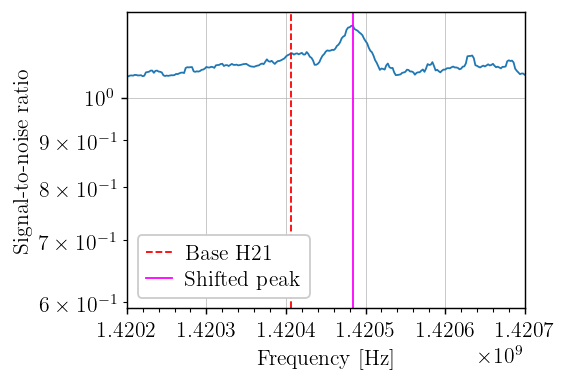

Spectrum [8]
Estimated relative velocity (l=27±1): (-16.51±4.22) km/s
Estimated actual velocity (l=27±1): (158.5±14.4) km/s


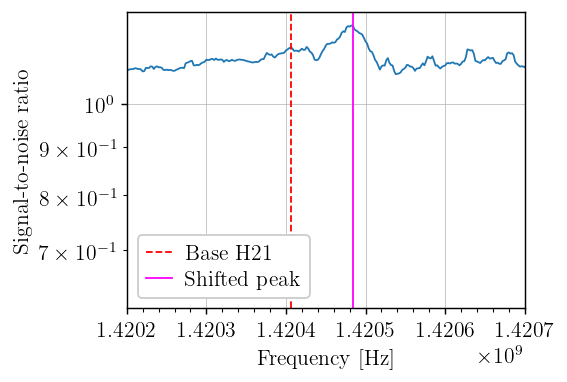

Spectrum [9]
Estimated relative velocity (l=30±1): (-16.51±4.22) km/s
Estimated actual velocity (l=30±1): (163.8±13.3) km/s


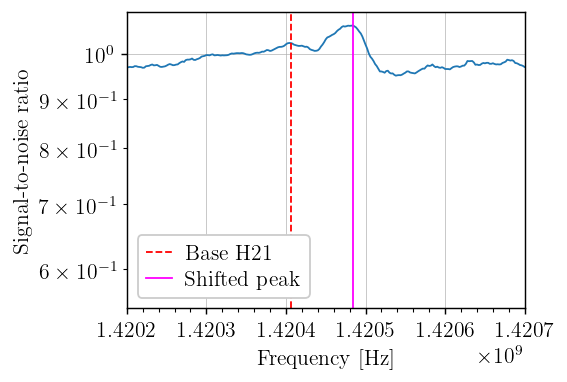

Spectrum [10]
Estimated relative velocity (l=33±1): (-13.98±4.22) km/s
Estimated actual velocity (l=33±1): (175.6±12.6) km/s


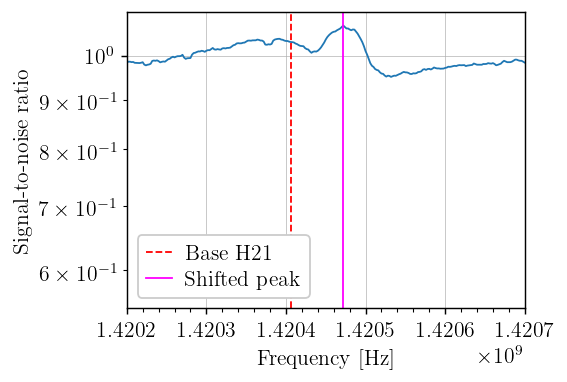

Spectrum [11]
Estimated relative velocity (l=36±1): (-14.83±4.22) km/s
Estimated actual velocity (l=36±1): (176.4±11.6) km/s


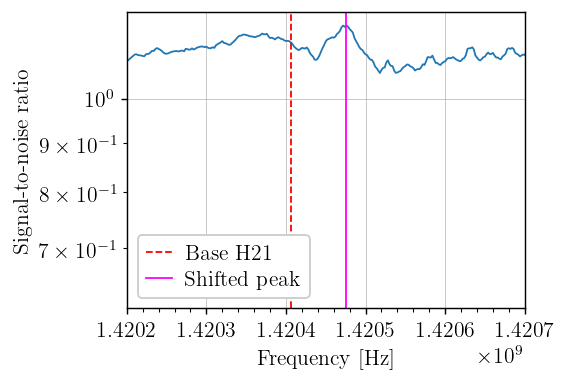

Spectrum [12]
Estimated relative velocity (l=39±1): (-13.98±4.22) km/s
Estimated actual velocity (l=39±1): (181.4±11.0) km/s


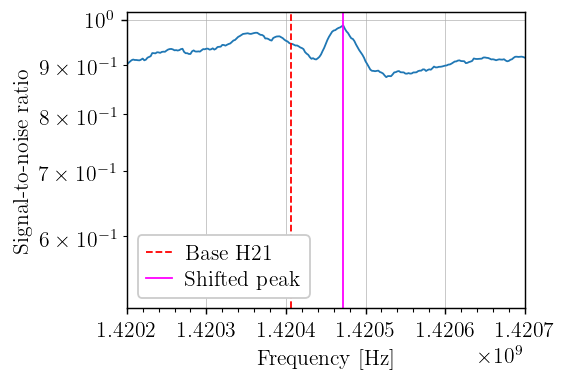

Spectrum [13]
Estimated relative velocity (l=42±1): (-13.98±4.22) km/s
Estimated actual velocity (l=42±1): (183.7±10.3) km/s


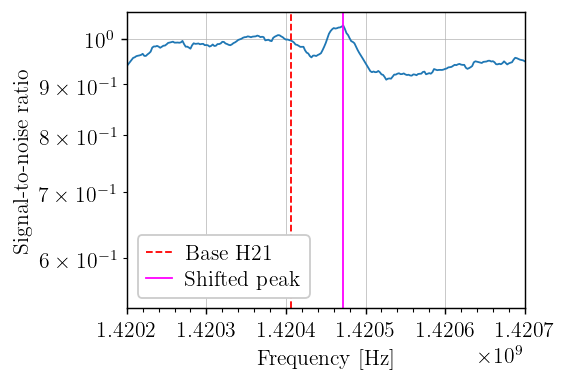

Spectrum [14]
Estimated relative velocity (l=45±1): (-11.45±4.22) km/s
Estimated actual velocity (l=45±1): (191.54±9.98) km/s


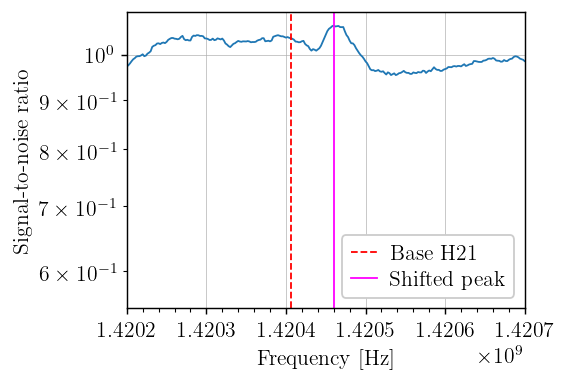

Spectrum [15]
Estimated relative velocity (l=48±1): (-11.03±4.22) km/s
Estimated actual velocity (l=48±1): (193.89±9.52) km/s


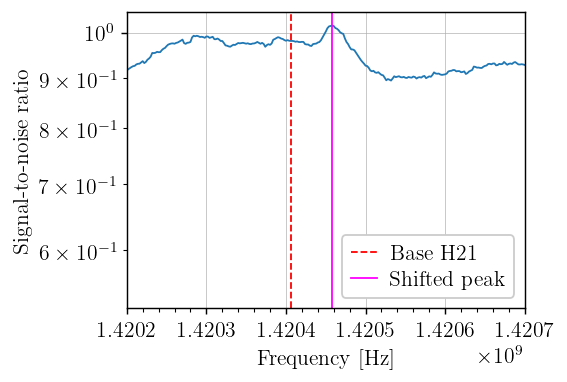

Spectrum [16]
Estimated relative velocity (l=51±1): (-10.18±4.22) km/s
Estimated actual velocity (l=51±1): (196.90±9.14) km/s


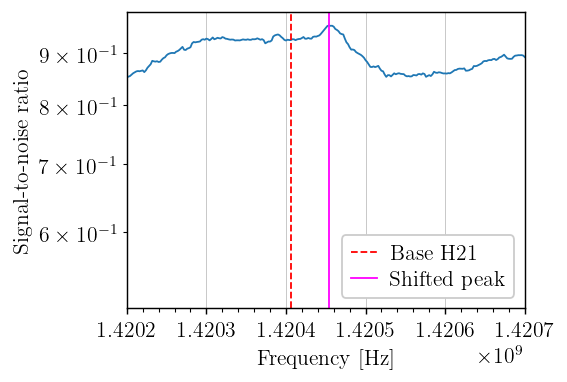

Spectrum [17]
Estimated relative velocity (l=54±1): (-3.43±4.22) km/s
Estimated actual velocity (l=54±1): (212.30±9.33) km/s


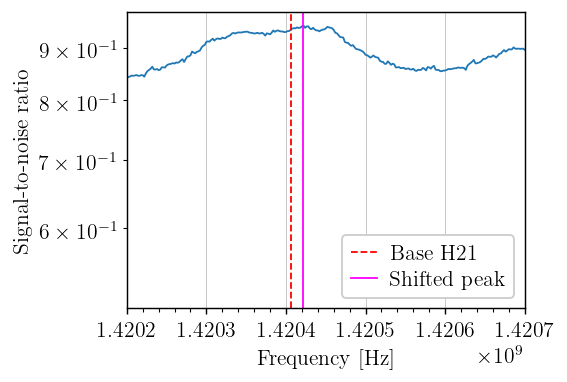

Spectrum [18]
Estimated relative velocity (l=54±1): (-3.43±4.22) km/s
Estimated actual velocity (l=54±1): (212.30±9.33) km/s


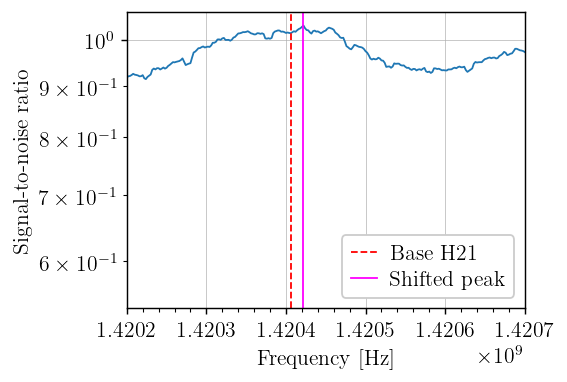

Spectrum [19]
Estimated relative velocity (l=57±1): (-4.27±4.22) km/s
Estimated actual velocity (l=57±1): (210.79±8.90) km/s


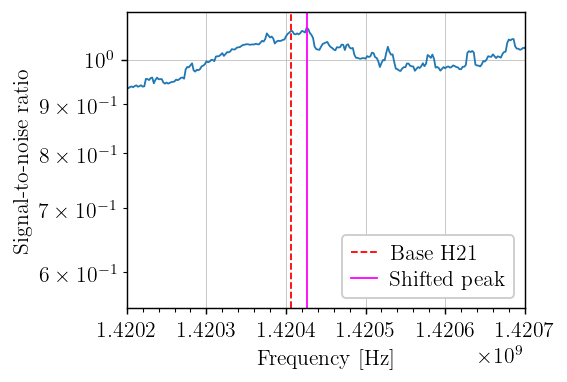

Spectrum [20]
Estimated relative velocity (l=60±1): (-4.27±4.22) km/s
Estimated actual velocity (l=60±1): (211.10±8.58) km/s


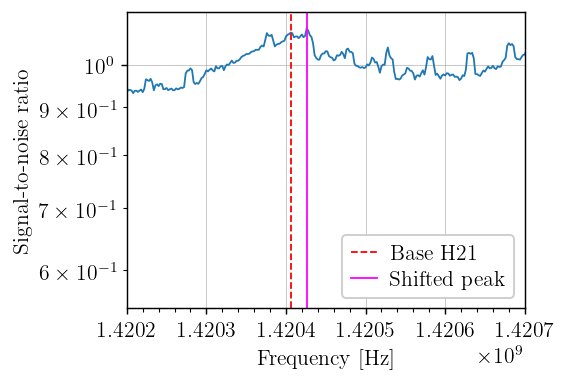

Spectrum [21]
Estimated relative velocity (l=63±1): (-69.69±4.22) km/s
Estimated actual velocity (l=63±1): (129.74±4.15) km/s


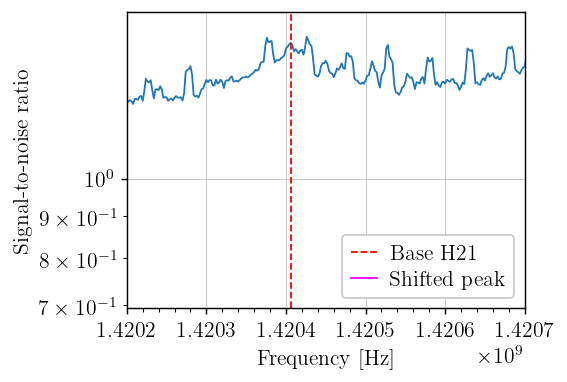

Spectrum [22]
Estimated relative velocity (l=66±1): (-4.27±4.22) km/s
Estimated actual velocity (l=66±1): (211.63±8.01) km/s


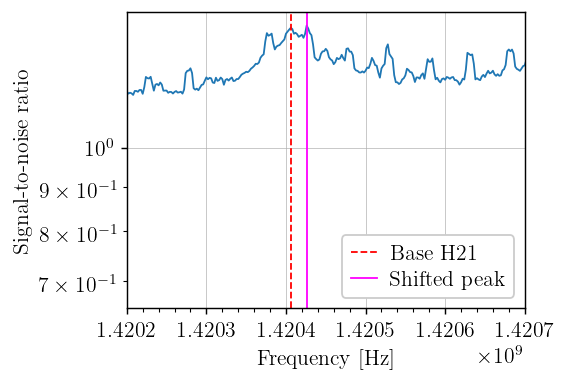

Spectrum [23]
Estimated relative velocity (l=69±1): (-0.05±4.22) km/s
Estimated actual velocity (l=69±1): (219.90±8.34) km/s


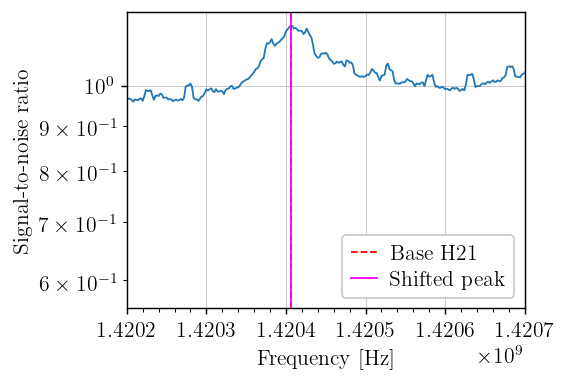

Spectrum [24]
Estimated relative velocity (l=72±1): (-69.26±4.22) km/s
Estimated actual velocity (l=72±1): (165.27±6.16) km/s


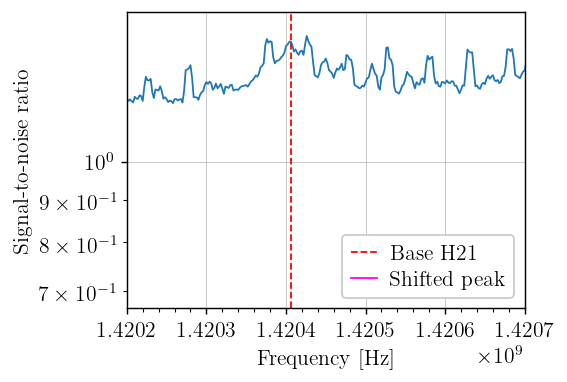

Spectrum [25]
Estimated relative velocity (l=75±1): (-69.69±4.22) km/s
Estimated actual velocity (l=75±1): (186.66±9.13) km/s


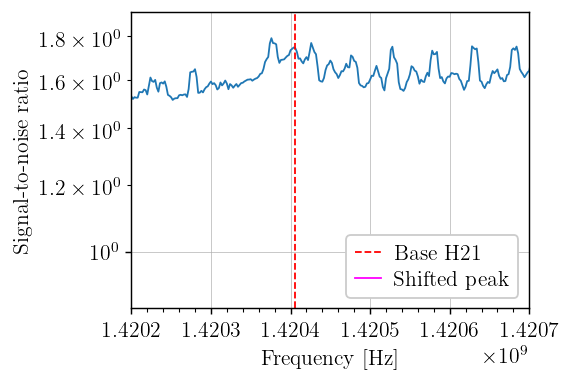

Spectrum [26]
Estimated relative velocity (l=78±1): (6.28±4.22) km/s
Estimated actual velocity (l=78±1): (222.39±2.61) km/s


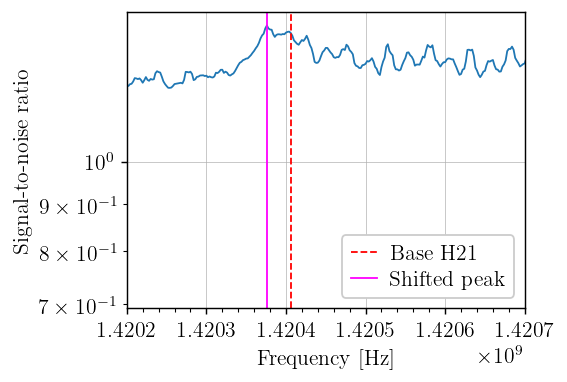

Spectrum [27]
Estimated relative velocity (l=81±1): (6.28±4.22) km/s
Estimated actual velocity (l=81±1): (223.57±4.26) km/s


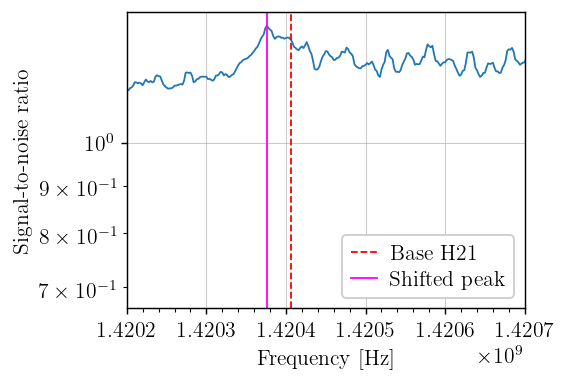

Spectrum [28]
Estimated relative velocity (l=84±1): (-69.69±4.22) km/s
Estimated actual velocity (l=84±1): (399.6±63.3) km/s


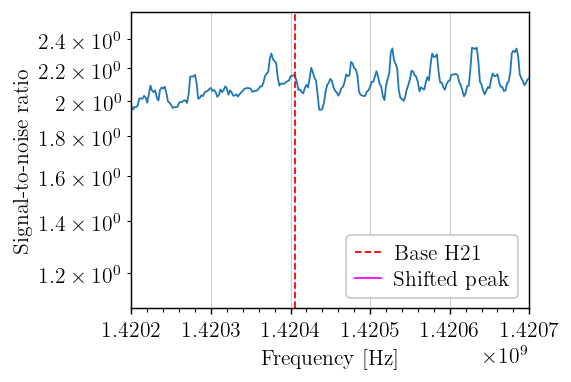

Spectrum [29]
Estimated relative velocity (l=87±1): (-69.26±4.22) km/s
Estimated actual velocity (l=87±1): (774±255) km/s


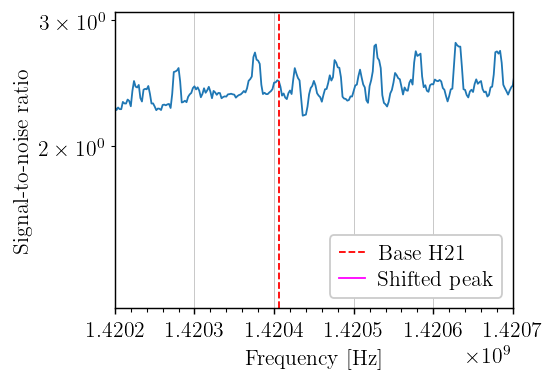

Spectrum [30]
Estimated relative velocity (l=93±1): (81.02±4.22) km/s
Estimated actual velocity (l=93±1): (1835±596) km/s


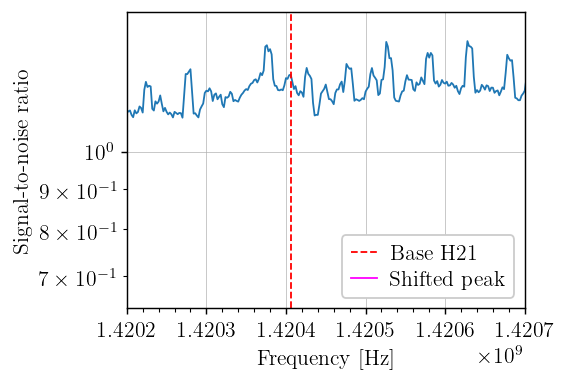

Spectrum [31]
Estimated relative velocity (l=96±1): (81.02±4.22) km/s
Estimated actual velocity (l=96±1): (982±150) km/s


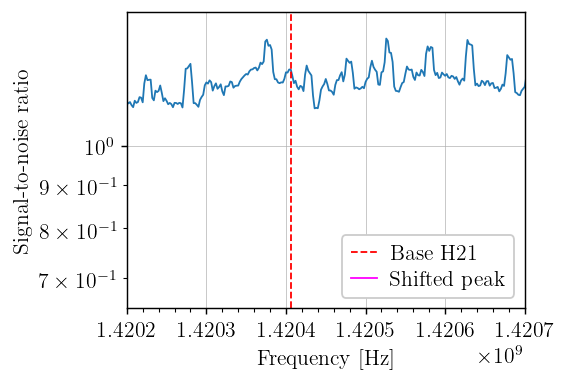

Spectrum [32]
Estimated relative velocity (l=99±1): (6.70±4.22) km/s
Estimated actual velocity (l=99±1): (235.7±11.9) km/s


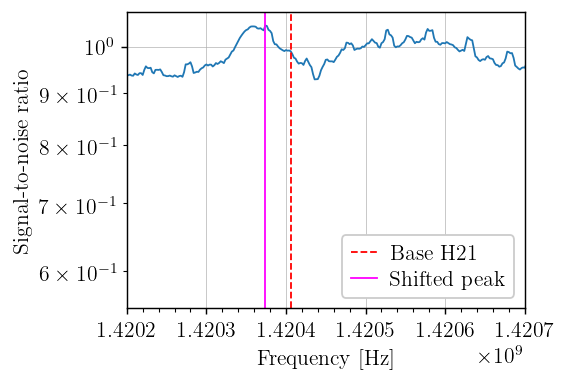

Spectrum [33]
Estimated relative velocity (l=102±1): (10.92±4.22) km/s
Estimated actual velocity (l=102±1): (245.6±11.8) km/s


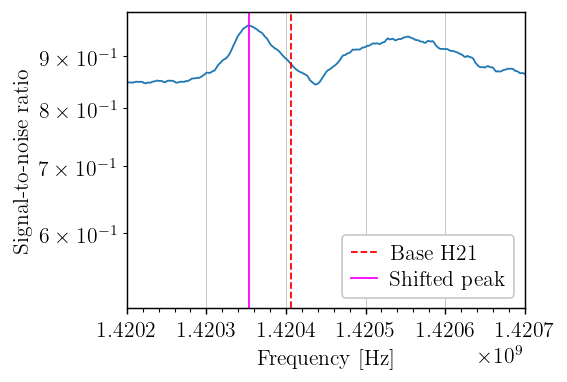

In [165]:
all_peaks = [None] * len(data)
all_peaks[19] = [725]
all_peaks[20] = [725]

distances = []
velocities = []
longitudes = []

compute = [True] * len(data)
# # Zone rajout manuel des peaks, enlever une fois que ça a été fait
# # Regarder [17, 18, 19, 20, 21, ...]
# compute = [False] * len(data)
# compute[21] = True

for i, ((spectrum, params), peaks) in enumerate(zip(data, all_peaks)):
    if (compute[i]):
        print(f"Spectrum [{i}]")
        dist, vel , l = do_the_processing_mate(freq, spectrum, params, noise, peaks_idx=peaks)
        distances.append(dist)
        velocities.append(vel)
        longitudes.append(l)
        plt.xlim(1.4202e9, 1.4207e9)
        plt.show()

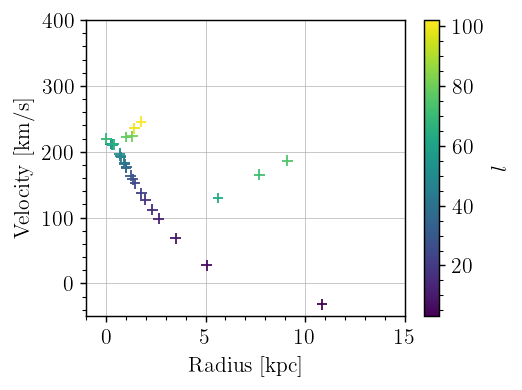

In [ ]:
plt.scatter([d.n for d in distances], [v.n / 1000 for v in velocities], c = [l.n for l in longitudes])

plt.xlim(-1,15)
plt.ylim(-50,400)

plt.xlabel('Radius [kpc]')
plt.ylabel('Velocity [km/s]')
plt.colorbar(label="$l$")

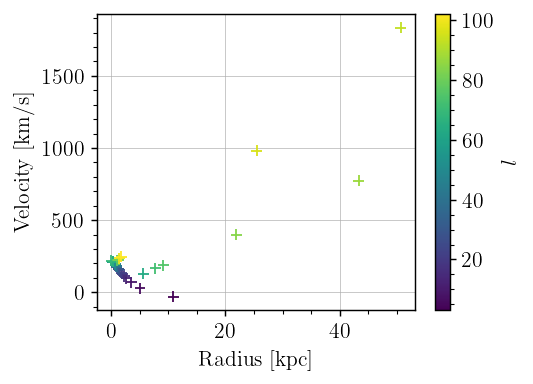

In [174]:
plt.scatter([d.n for d in distances], [v.n / 1000 for v in velocities], c = [l.n for l in longitudes])

plt.xlabel('Radius [kpc]')
plt.ylabel('Velocity [km/s]')
plt.colorbar(label="$l$")